# Методы отбора признаков

Это процесс отбора подмножества значимых признаков для использования в построении модели. Методы отбора применяют в случаях когда нужно сократить количество признаков для:
- ускорения алгоритмов обучения
- уменьшения потребляемой памяти
- избавления от неинформативных признаков и выбросов

Прежде, чем описывать алгоритмы, подготовим среду *jupyter notebook*.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

И установим внешние зависимости:

In [2]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plot
from sklearn import datasets

Также понадобятся вспомогательные методы.

1. Получает на вход выборку `dataset`. Ожидается, что `dataset` будет взят из `sklearn/datasets`, но можно любую структуру данных с аналогичным интерфейсом.

In [3]:
def get_feature_count(dataset):
    return len(dataset.data[0])

2. Получает на вход выборку `dataset` и массив прикнаков `feature`. Выбирает из выборки только признаки из `feature`, проводит по ним обучение (взял *наивного Байеса*), проводит классификацию и возвращает количество допущенных ошибок.

In [4]:
from sklearn.naive_bayes import GaussianNB

def count_error(dataset, features):
    data = dataset.data[:, features]

    gnb = GaussianNB()
    gnb.fit(data, dataset.target)

    y_predict = gnb.predict(data)

    return (dataset.target != y_predict).sum()

## Полный перебор

Полный перебор даёт 100% гарантию наилучшего ответа. Очевидно, что сложность алгоритма *экспоненциальная* и при большом количестве признаков умноженном на скорость обучения ответа можно не дождаться.

Алгоритм перебирает всевозможные наборы прикнаков и из наилучшего берет с наименьшим количеством признаков.

Введём вспомогательную функцию, которая будет по количеству признаков возвращать генераторы комбинаций прикнаков:

In [5]:
def __feat_gen(count):
    for c in range(1, count + 1):
        arr = list(range(count))
        comb = combinations(arr, c)

        yield from comb

Функция полного перебора признаков на вход получает выборку `dataset`, возвращает словарь с интерфейсом:
- `features` – массив признаков, дающий наименьшую ошибку
- `error` – ошибка
- `log`

где `log` – массив логов обхода алгоритма, вида:
- `error` – ошибка
- `feature_count` – количество признаков
Этот массив нужен для построения графиков.

**Все последующие функции отбора признаков имеют такой же тип ответа.**

In [6]:
def selection_full_search(dataset):
    feature_count = get_feature_count(dataset)
    log = []
    result = {
        "error": 9999,
        "features": [],
        "log": log
    }

    for feat_cur in __feat_gen(feature_count):
        error = count_error(dataset, feat_cur)

        log.append({
            "error": error,
            "feature_count": len(feat_cur)
        })

        if error < result["error"]:
            result = {
                "error": error,
                "features": feat_cur,
                "log": log
            }

    return result

Построим график поиска решений **полным перебором** на выборке `breast_cancer` по первым 15 признакам из библиотеки `sklearn`.

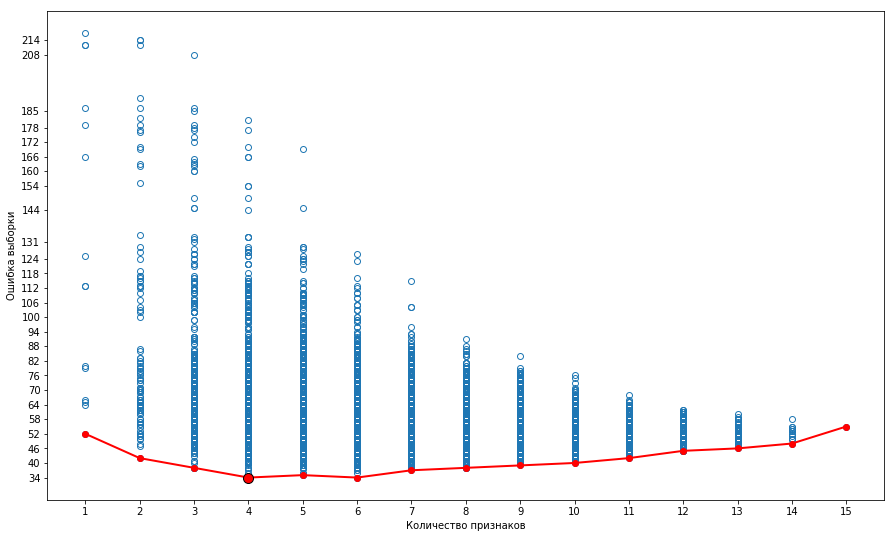

Лучшая выборка:  (1, 7, 11, 14)  даёт ошибку  34


In [7]:
from feature_selection.plot import make_plot

dataset = datasets.load_breast_cancer()
feature_count = 15
dataset.data = dataset.data[:, :feature_count]

plot.rcParams['figure.figsize'] = (15, 9)
plot.figure()

result = selection_full_search(dataset)
make_plot(dataset, result)
plot.show()

print("Лучшая выборка: ", result["features"], " даёт ошибку ", result["error"])

На выборке из 15 признаков лучший ответ получен при 4х признаках с ошибкой = 34. Синими кружками обозначаются все попытки полного перебора найти решение.

**Сравнение результатов будет в конце**

## Алгоритм ADD

Является жадным алгоритмом. Начинает с набора признаков `= []`. Добавляет в набор по одному наилучшему признаку до тех пор, пока качество алгоритма не начинает ухудшаться.

Второй параметр алгоритма введён только для **алгоритма ADD-DEL**. Про него можно прочитать ниже.

In [8]:
def selection_add(dataset, result=None):
    feature_count = get_feature_count(dataset)
    log = []
    if result is None:
        result = {
            "error": 9999,
            "features": [],
            "log": log
        }

    while True:
        result_cur = result

        for feat in range(feature_count):
            if feat in result["features"]:
                continue

            features = result["features"] + [feat]
            features.sort()

            error = count_error(dataset, features)

            log.append({
                "error": error,
                "feature_count": len(features)
            })

            if error <= result_cur["error"]:
                result_cur = {
                    "error": error,
                    "features": features,
                    "log": log
                }

        if result_cur == result:
            break

        result = result_cur

    return result

Запустим **ADD** на той же выборке, что и **полный перебор**. Однако, сделаем это не на 15, а на 30ти признаках, так как алгоритм имеет меньшую по асимптотике сложность:

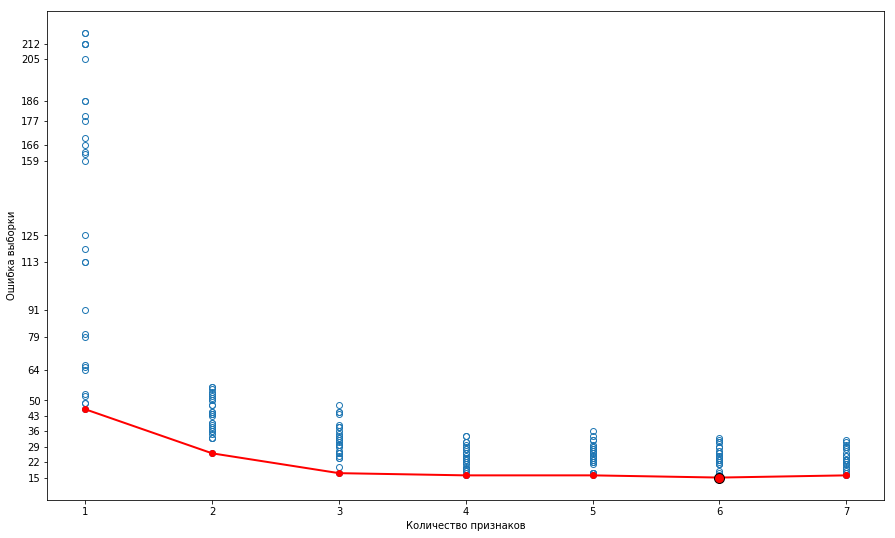

Лучшая выборка:  [11, 16, 18, 21, 22, 24]  даёт ошибку  15


In [9]:
dataset = datasets.load_breast_cancer()
feature_count = 30
dataset.data = dataset.data[:, :feature_count]

result = selection_add(dataset)
make_plot(dataset, result)
plot.show()

print("Лучшая выборка: ", result["features"], " даёт ошибку ", result["error"])

Алгоритм закончил работу на 6м признаке из 30ти, т.к. при присоединении 7го признака его ошибка возросла. Однако, алгоритму не обязательно заканчивать работу на этом этапе, он может продолжать работу и дальше, запомня лучший результат. Это всего лишь интерпретация алгоритма в учебных целях.

## Алгоритм DEL

Является жадным алгоритмом. Начинает с набора признаков = полному количеству признаков.
На каждом шаге удаляет по одному наихудшему признаку до тех пор, пока качество алгоритма не ухудшается.

Второй параметр алгоритма введён только для **алгоритма ADD-DEL**. Про него можно прочитать ниже.

In [10]:
def selection_del(dataset, result=None):
    feature_count = get_feature_count(dataset)
    log = []
    if result is None:
        features_all = list(range(feature_count))
        error = count_error(dataset, features_all)

        log.append({
            "error": error,
            "feature_count": feature_count
        })

        result = {
            "error": error,
            "features": features_all,
            "log": log
        }

    while len(result["features"]) > 1:
        result_cur = result

        for feat in result["features"]:
            features = result["features"][:]
            features.remove(feat)

            error = count_error(dataset, features)

            log.append({
                "error": error,
                "feature_count": len(features)
            })

            if error <= result_cur["error"]:
                result_cur = {
                    "error": error,
                    "features": features,
                    "log": log
                }

        if result_cur == result:
            break

        result = result_cur

    return result


Запустим **DEL** аналогично алгоритму **ADD**:

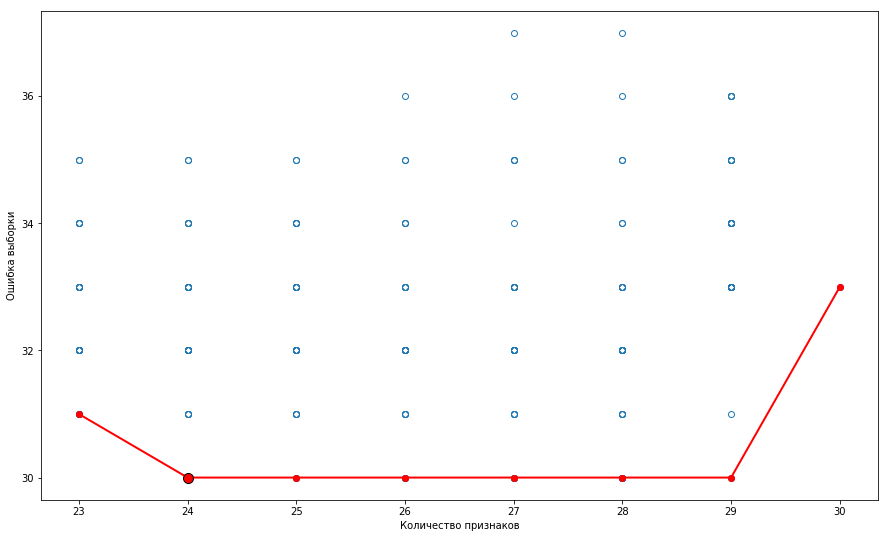

Лучшая выборка:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 25, 27, 28, 29]  даёт ошибку  30


In [11]:
result = selection_del(dataset)
make_plot(dataset, result)
plot.show()

print("Лучшая выборка: ", result["features"], " даёт ошибку ", result["error"])

## Алгоритм ADD-DEL

Является комбинацией **ADD** и **DEL**. Начинает с набора признаков `= []`. Далее итеративно сначала применяет **ADD** алгоритм, потом **DEL** алгоритм. Эти шаги повторяются итеративно, пока качество алгоримта растёт. Таким образом, является небольшим улучшением **ADD** алгоритма, позволяя избавить от "лишне собранных" признаков и продолжить использовать жадный метод выбора признаков.

In [12]:
def selection_add_del(dataset):
    log = []
    result = {
        "error": 9999,
        "features": [],
        "log": log
    }

    while True:
        new_result = selection_add(dataset, result)
        new_result = selection_del(dataset, new_result)

        if new_result["error"] >= result["error"]:
            break

        result = new_result

    return result

Алгоритм также можно начать и с **DEL** метода, потом применяя **ADD**. Поменяется только изначальная выборка. Она будет не пустая, а содержать все признаки.

## Сравнение Полного перебора, ADD, DEL, ADD-DEL

Сравним результаты редукции выборки разных алгоритмов на выборке `breast_cancer` по первым 12 признакам из библиотеки `sklearn`.

In [13]:
from sklearn import datasets


dataset = datasets.load_breast_cancer()
feature_count = 12
dataset.data = dataset.data[:, :feature_count]


def __log(message, result):
    print(message)
    print("Количество ошибок: ", result["error"])
    print("Количество признаков: ", len(result["features"]))
    print("Признаки: ", np.asarray(result["features"]))
    print("-------------------------------------------")


features_all = list(range(feature_count))
__log("Полный набор признаков", {
    "error": count_error(dataset, features_all),
    "features": features_all
})

__log("Полный перебор", selection_full_search(dataset))

__log("Алгоритм ADD", selection_add(dataset))

__log("Алгоритм DEL", selection_del(dataset))

__log("Алгоритм ADD-DEL", selection_add_del(dataset))

Полный набор признаков
Количество ошибок:  48
Количество признаков:  12
Признаки:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
-------------------------------------------
Полный перебор
Количество ошибок:  35
Количество признаков:  5
Признаки:  [0 1 4 6 8]
-------------------------------------------
Алгоритм ADD
Количество ошибок:  36
Количество признаков:  4
Признаки:  [ 0  1  7 11]
-------------------------------------------
Алгоритм DEL
Количество ошибок:  40
Количество признаков:  3
Признаки:  [0 1 7]
-------------------------------------------
Алгоритм ADD-DEL
Количество ошибок:  36
Количество признаков:  4
Признаки:  [ 0  1  7 11]
-------------------------------------------


Также можем проследить поиск ответов различных алгортмов при различном количестве призаков на общем графике:

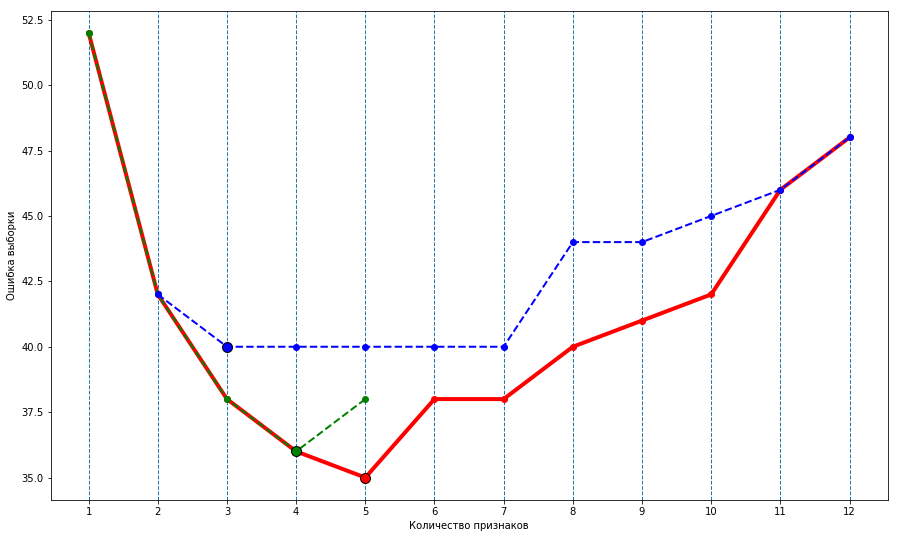

In [14]:
from feature_selection.plot import make_compare_plot

dataset = datasets.load_breast_cancer()
feature_count = 12
dataset.data = dataset.data[:, :feature_count]

make_compare_plot(dataset, selection_full_search(dataset), draw_ticks=True, linewidth=4)
make_compare_plot(dataset, selection_add(dataset), color='green', linestyle='--')
make_compare_plot(dataset, selection_del(dataset), color='blue', linestyle='--')
plot.show()

Как можно увидеть, **полный перебор** является лидером по наименьшей ошибке. Алгориты **ADD**, **DEL** и **ADD-DEL** дали
близкий к **полному перебору** ответ. Маленький разрыв легко объяснить небольшим количеством фичей, маленькой выбркой и
тривиальностью выборки. На практике этот разрыв будет большой. Тут важно увидеть, что жадные алгоритмы в погоне за жадностью
не увидели, что набор "менее полезных признаков" в совокупности дал наибольший результат.

## Алгоритм обхода в глубину (DFS)

Этот алгоритм – оптимизация полного перебора признаков с отсечением вариантов. Эвристика такова: на каждом шаге **наращивания** выборки следить, не встречалась ли ранее выборка с меньшей ошибкой и меньшим количеством признаков. И если была, текущую выборку при обходе отбрасываем, не пытаясь ее улучшать.

Алгоритм эвристический, поэтому за счет улучшения сложности даёт ошибку. И качество результата зависит от того, в каком порядке расположены признаки. Обязательной частью алгоритма является сортировка признаков по *полезности* перед началом обхода. Без этой сортировки алгоритм даёт результаты гораздо хуже и не имеет большого смысла.

*В рамках алгоритма условимся, что фича – это словарь с полями `{i: номер признака, pos: порядковый номер признака при сортировке полезности}`*.

In [15]:
def __sort_features(dataset):
    feature_count = get_feature_count(dataset)
    feature_errors = list(map(lambda i: {"i": i, "error": count_error(dataset, [i])}, range(feature_count)))
    features_sorted = list(sorted(feature_errors, key=lambda x: x["error"]))
    return list(map(lambda f, pos: {"i": f["i"], "pos": pos}, features_sorted, range(feature_count)))

Чтобы в дереве обхода не было одинаковых наборов признаков, добавляем на этапе **наращивания** только те признаки, что больше текущих по коэффициенту.

*Функция получения наибольшего порядкового номера выборки:*

In [16]:
def __max_feature_pos(features):
    return max(features, key=lambda f: f["pos"])["pos"] if len(features) != 0 else -1

*Также понадобится функция преобразующая `{i, pos}` в массив номеров признаков*:

In [17]:
def __flatten_features(features):
    return list(map(lambda f: f["i"], features))

Основной частью алгоритма является **наращивание** текущего набора признаков для дальнейшего обхода. Функция рекурсивная и продолжает обход лишь в том случае, если на ранних этапах не было выборки с лучшим показателем. Иначе она запоминает текущий результат и рекурсивно прибавляет к текущей выборки не использованные номера признаков:

In [18]:
def __increase(features_cur, features, results, dataset, logs):
    length = len(features_cur)
    result = results[length]
    error = count_error(dataset, __flatten_features(features_cur)) if length != 0 else 9999

    if error != 9999:
        logs.append({
            "error": error,
            "feature_count": length
        })

    for j in range(length):
        if results[j]["error"] < error:
            return

    if error < result["error"]:
        result["error"] = error
        result["features"] = features_cur

    max_feature = __max_feature_pos(features_cur)
    for feature in features:
        if feature["pos"] > max_feature:
            __increase(features_cur + [feature], features, results, dataset, logs)

Собственно, *сам алгоритм* при таком разбиении на функции становится простым:

In [19]:
def selection_dfs(dataset):
    feature_count = get_feature_count(dataset)
    features = __sort_features(dataset)

    logs = []
    results = list(map(lambda x: {"error": 9999, "features": []}, range(feature_count + 1)))

    __increase([], features, results, dataset, logs)

    result = min(results, key=lambda x: x["error"])
    result["features"] = sorted(__flatten_features(result["features"]))
    result["log"] = logs

    return result

Протестируем алгоритм на выборке из 30ти признаков:

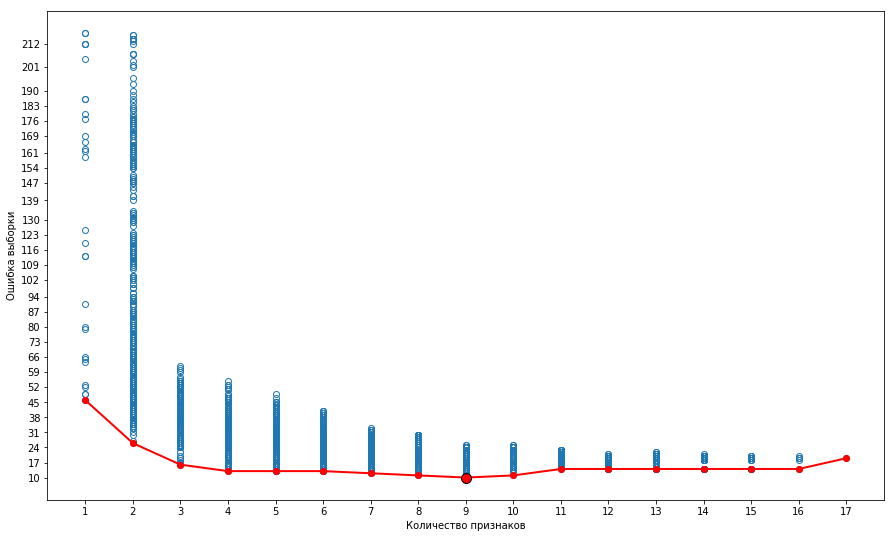

Лучшая выборка:  [1, 16, 17, 18, 20, 21, 22, 24, 27]  даёт ошибку  10


In [20]:
dataset = datasets.load_breast_cancer()
feature_count = 30
dataset.data = dataset.data[:, :feature_count]

result = selection_dfs(dataset)
make_plot(dataset, result)
plot.show()

print("Лучшая выборка: ", result["features"], " даёт ошибку ", result["error"])

## Алгоритм обхода в ширину (BFS)

Этот алгоритм является улучшением алгоритма **ADD**. Улучшение состоит в том, что на каждой итерации мы запоминаем не один лучший набор признаков, а `iter_limit` наборов. И наращивание происходит не по 1 набору, а сразу по `iter_limit` наборам.

В случае, когда `iter_limit = 1`, алгоритм равен **ADD**. Сложность работы алгоритма вырастает в `iter_limit` раз.

In [21]:
def selection_bfs(dataset, iter_limit=1):
    feature_count = get_feature_count(dataset)
    logs = []
    result_best = {
        "error": 9999,
        "features": [],
        "log": logs
    }

    result = list(map(lambda i: {"features": [i]}, range(feature_count)))

    for iteration in range(1, feature_count + 1):
        for res in result:
            res["error"] = count_error(dataset, res["features"])

            logs.append({
                "error": res["error"],
                "feature_count": len(res["features"])
            })

        result.sort(key=lambda r: r["error"])

        if len(result) > iter_limit:
            result = result[:iter_limit]

        if result[0]["error"] > result_best["error"]:
            break

        if result[0]["error"] < result_best["error"]:
            result_best = result[0]

        result_new = []
        for res in result:
            for i in range(feature_count):
                if i not in res["features"]:
                    result_new.append({"features": res["features"] + [i]})

        result = result_new

    result_best["features"].sort()
    result_best["log"] = logs

    return result_best

Протестируем алгоритм на выборке из 30ти признаков:

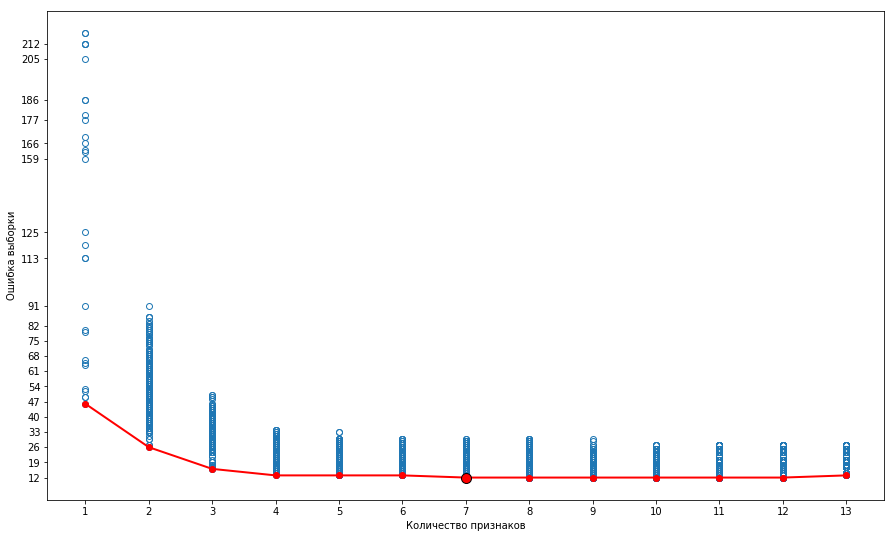

Лучшая выборка:  [1, 16, 17, 21, 23, 24, 27]  даёт ошибку  12


In [22]:
result = selection_bfs(dataset, iter_limit=10)
make_plot(dataset, result)
plot.show()

print("Лучшая выборка: ", result["features"], " даёт ошибку ", result["error"])

## Сравнение ADD, DFS, BFS

Воспользуемся выборкой `breast_cancer` по всем 30 признакам и сравним 2 алгоритма друг с другом, а также насколько они лучше предыдущих жадных на примере **ADD**.

Сравнить с **полным перебором** к сожалению не выйдет из-за большой размерности выборки.

In [23]:
dataset = datasets.load_breast_cancer()
feature_count = 30
dataset.data = dataset.data[:, :feature_count]

__log("Алгоритм ADD", selection_add(dataset))
__log('Поиск в глубину', selection_dfs(dataset))
__log('Поиск в ширину', selection_bfs(dataset, iter_limit=10))

Алгоритм ADD
Количество ошибок:  15
Количество признаков:  6
Признаки:  [11 16 18 21 22 24]
-------------------------------------------
Поиск в глубину
Количество ошибок:  10
Количество признаков:  9
Признаки:  [ 1 16 17 18 20 21 22 24 27]
-------------------------------------------
Поиск в ширину
Количество ошибок:  12
Количество признаков:  7
Признаки:  [ 1 16 17 21 23 24 27]
-------------------------------------------


Также сравним их методы поиска на общем графике:

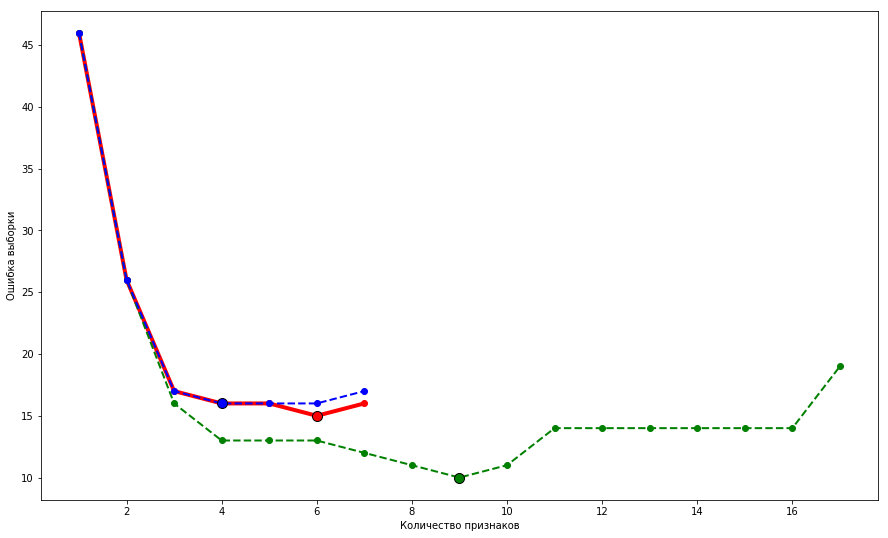

In [25]:
make_compare_plot(dataset, selection_add(dataset), linewidth=4)
make_compare_plot(dataset, selection_dfs(dataset), color='green', linestyle='--')
make_compare_plot(dataset, selection_bfs(dataset), color='blue', linestyle='--')

Видно, что **BFS** очень похож на **ADD** и отличие начинается в том месте, где **BFS** среди множества решений нашёл лучше, чем **ADD**.
Поиск в глубину показал себя наиболее эффективным за счёт того, что он пытается оптимизировать полный перебор, а не улучшить жадный алгоритм.